In [1]:
import os
os.makedirs('output', exist_ok=True)

import sys
sys.path.append('../')

from utils import load_walksheds, overlay_wks
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from geopandas.tools import overlay
warnings.filterwarnings('ignore')

* ctpp_jobs contains the total workers 16 years old and over
* dc_jobs, md_jobs, and va_jobs contain the Traffic Analysis Zone (taz) boundaries for DC, MD and VA
* load in the walksheds contains the overlapping .5 mile walksheds and .75 miles for the study area
* mstns contains the new station names and MSTN IDs

In [2]:
ctpp_jobs= pd.read_csv("A202100 - Total Workers (1) (Workers 16 years and over).csv", skiprows=[0,1])
dc_jobs = gpd.read_file("../../Data/tl_2011_11_taz10_dc/")
md_jobs = gpd.read_file("../../Data/tl_2011_24_taz10_md")
va_jobs = gpd.read_file("../../Data/tl_2011_51_taz10_va")
mstns = pd.read_excel("../../Data/mstn_id_to_stn_name.xlsx")

In [3]:
wksp5, wksp75 = load_walksheds()

In [4]:
ctpp_jobs.head()

,WORKPLACE,Output,Workers 16 and Over,Unnamed: 3
0,Alabama,Estimate,"1,967,290",NaN
1,Alabama,Margin of Error,"6,980",NaN
2,Alaska,Estimate,"368,140",NaN
3,Alaska,Margin of Error,"2,066",NaN
4,Arizona,Estimate,"2,816,865",NaN


* Concatenate all three of the regions into one boundaries geodataframe
* Filter the ctpp_jobs for the estimates instead of the margin of errors
* Filter the workplace geometries for those that
* Take only the 4th-12th characters from the TAZ ID column so that the jobs csv can merge with the boundaries
* Join the ctpp jobs data with the boundaries

In [5]:
boundaries = [dc_jobs, md_jobs, va_jobs]
all_boundaries = gpd.GeoDataFrame(pd.concat(boundaries, ignore_index=True) )

In [6]:
ctpp_jobs2 = ctpp_jobs[ctpp_jobs['Output']=='Estimate']

In [7]:
ctpp_jobs3 = ctpp_jobs2[ctpp_jobs2['WORKPLACE'].str.contains("TAZ")]

In [8]:
ctpp_jobs3['TAZCE10'] = ctpp_jobs3['WORKPLACE'].str[4:12]

In [9]:
Join_Jobs_Boundaries=pd.merge(all_boundaries, ctpp_jobs3, on='TAZCE10', how='left')

<Axes: >

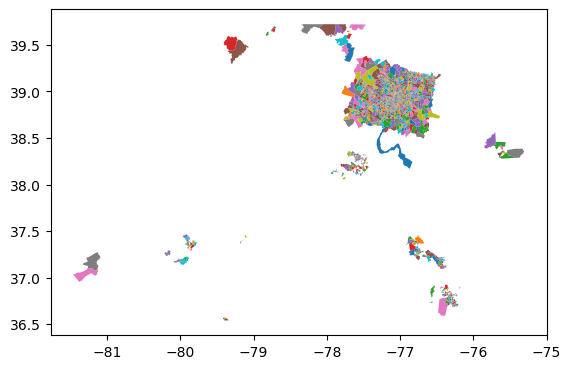

In [10]:
Join_Jobs_Boundaries.plot(column = 'Workers 16 and Over')

* Change the crs of the combined jobs-boundaries to match with the walksheds
* Create a column with the the full area of each TAZ
* Intersect the walksheds with the boundaries
* Create a column with the partial area of each TAZ after the intersection

In [11]:
Join_Jobs_Boundaries = Join_Jobs_Boundaries.to_crs(wksp5.crs)

In [12]:
Join_Jobs_Boundaries['fullarea'] = Join_Jobs_Boundaries.area # square meter; blocks' areas

In [13]:
intp5_stations_Jobs, intp75_stations_Jobs = overlay_wks(Join_Jobs_Boundaries)

In [14]:
intp5_stations_Jobs['partialarea'] = intp5_stations_Jobs.area  # each block is within which specific walkshedbuffer
intp75_stations_Jobs['partialarea'] = intp75_stations_Jobs.area  

* Remove extra strings from the station names
* Convert the number of workers from a string to an integer by removing the commas and apply the integer type
* Group the intersected walksheds and TAZ boundaries by the station names and sum the number of workers

In [15]:
intp5_stations_Jobs['Workers 16 and Over'] = intp5_stations_Jobs['Workers 16 and Over'].replace(',','', regex=True)
intp5_stations_Jobs['Workers 16 and Over'] = intp5_stations_Jobs['Workers 16 and Over'].astype(int)

intp75_stations_Jobs['Workers 16 and Over'] = intp75_stations_Jobs['Workers 16 and Over'].replace(',','', regex=True)
intp75_stations_Jobs['Workers 16 and Over'] = intp75_stations_Jobs['Workers 16 and Over'].astype(int)

In [16]:
Sum_job_bufstation_p5 = intp5_stations_Jobs.groupby(['Name_1'])[['Workers 16 and Over']].apply(sum)   
Sum_job_bufstation_p75 = intp75_stations_Jobs.groupby(['Name_1'])[['Workers 16 and Over']].apply(sum)   

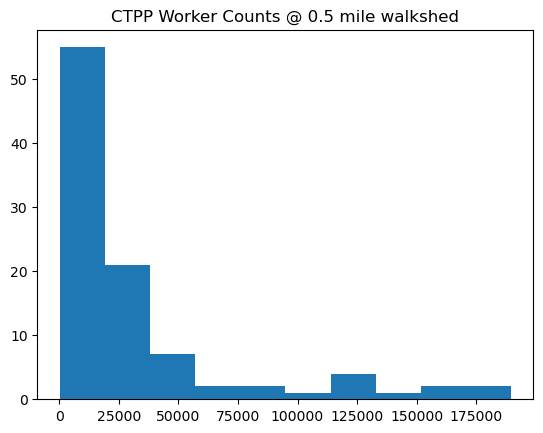

In [17]:
plt.hist(Sum_job_bufstation_p5['Workers 16 and Over'])
plt.title("CTPP Worker Counts @ 0.5 mile walkshed");

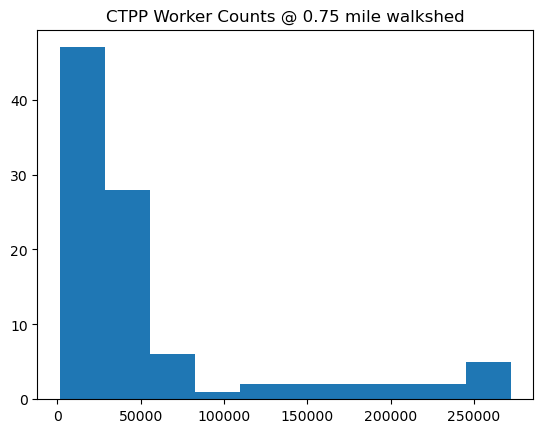

In [18]:
plt.hist(Sum_job_bufstation_p75['Workers 16 and Over'])
plt.title("CTPP Worker Counts @ 0.75 mile walkshed");

* Create the multiplier to get the percent full TAZ area within a walkshed
* Multiply the multiplier by the number of workers
* Reset the index
* Create a column of old station names in the mstns dataframe for easy merging
* Merge the mstn ids to the jobs
* Export to Excel

In [19]:
totalarea_station_p5 = intp5_stations_Jobs.groupby(['Name_1'])[['fullarea']].apply(sum)
partialarea_station_p5 = intp5_stations_Jobs.groupby(['Name_1'])[['partialarea']].apply(sum)
multiplier_p5 = partialarea_station_p5['partialarea']/totalarea_station_p5['fullarea']


totalarea_station_p75 = intp75_stations_Jobs.groupby(['Name_1'])[['fullarea']].apply(sum)
partialarea_station_p75 = intp75_stations_Jobs.groupby(['Name_1'])[['partialarea']].apply(sum)
multiplier_p75 = partialarea_station_p75['partialarea']/totalarea_station_p75['fullarea']

In [20]:
Sum_job_bufstation_p5['proportionjobs'] = Sum_job_bufstation_p5.multiply(multiplier_p5, axis="index")

Sum_job_bufstation_p75['proportionjobs'] = Sum_job_bufstation_p75.multiply(multiplier_p75, axis="index")


In [21]:
Sum_job_bufstation_p5

,Workers 16 and Over,proportionjobs
Name_1,,
ADDISON ROAD-SEAT PLEASANT,1030,116.608128
ANACOSTIA,9715,1763.609330
ARCHIVES-NAVY MEMORIAL-PENN QUARTER,122395,56593.758076
ARLINGTON CEMETERY,295,35.889127
Ashburn,2790,278.607874
...,...,...
WHEATON,5990,1113.074724
WHITE FLINT,22075,2795.719321
WIEHLE-RESTON EAST,26325,1874.284731


In [22]:
Sum_job_bufstation_p5.reset_index(inplace=True)
Sum_job_bufstation_p75.reset_index(inplace=True)

In [23]:
mstns.sort_values(by = 'PRIMARY_NAME_FY23',inplace=True)
mstns['walkshed_filename'] = ['ADDISON ROAD-SEAT PLEASANT','ANACOSTIA','ARCHIVES-NAVY MEMORIAL-PENN QUARTER','ARLINGTON CEMETERY','Ashburn','BALLSTON-MU',
                              'BENNING ROAD','BETHESDA','BRADDOCK ROAD','BRANCH AVE','BROOKLAND-CUA','CAPITOL HEIGHTS','CAPITOL SOUTH','CHEVERLY',
                              'CLARENDON','CLEVELAND PARK','COLLEGE PARK-U OF MD','COLUMBIA HEIGHTS','CONGRESS HEIGHTS','COURT HOUSE','CRYSTAL CITY',
                              'DEANWOOD','LARGO TOWN CENTER','Washington Dulles International Airport', 'DUNN LORING-MERRIFIELD','DUPONT CIRCLE','EAST FALLS CHURCH','EASTERN MARKET','EISENHOWER AVENUE','FARRAGUT NORTH',
                              'FARRAGUT WEST','FEDERAL CENTER SW','FEDERAL TRIANGLE','FOGGY BOTTOM-GWU','FOREST GLEN','FORT TOTTEN','FRANCONIA-SPRINGFIELD',
                              'FRIENDSHIP HEIGHTS','GALLERY PL-CHINATOWN','GEORGIA AVE-PETWORTH','GLENMONT','GREENBELT','GREENSBORO','GROSVENOR-STRATHMORE',
                              'Herndon','HUNTINGTON',"PRINCE GEORGE'S PLAZA",'Innovation Center','JUDICIARY SQUARE','KING ST-OLD TOWN',"L'ENFANT PLAZA",'LANDOVER',
                              'Loudoun Gateway','MCLEAN','MCPHERSON SQUARE','MEDICAL CENTER','METRO CENTER','MINNESOTA AVE','MORGAN BOULEVARD',
                              'MT VERNON SQ 7TH ST-CONVENTION CENTER','NAVY YARD-BALLPARK','NAYLOR ROAD','NEW CARROLLTON','NOMA-GALLAUDET','WHITE FLINT','PENTAGON',
                              'PENTAGON CITY','POTOMAC AVE', "",'Reston Town Center','RHODE ISLAND AVE-BRENTWOOD','ROCKVILLE','RONALD REAGAN WASHINGTON NATIONAL AIRPORT',
                              'ROSSLYN','SHADY GROVE','SHAW-HOWARD U','SILVER SPRING','SMITHSONIAN','SOUTHERN AVENUE','SPRING HILL',
                              'STADIUM-ARMORY','SUITLAND','TAKOMA','TENLEYTOWN-AU','TWINBROOK','TYSONS CORNER','U STREET/AFRICAN-AMER CIVIL WAR MEMORIAL/CARDOZO',
                              'UNION STATION','VAN DORN STREET','VAN NESS-UDC','VIENNA/FAIRFAX-GMU','VIRGINIA SQUARE-GMU','WATERFRONT','WEST FALLS CHURCH-VT/UVA',
                              'WEST HYATTSVILLE','WHEATON','WIEHLE-RESTON EAST','WOODLEY PARK-ZOO/ADAMS MORGAN',]

In [24]:
jobs_mstns_p5 = mstns.merge(Sum_job_bufstation_p5, left_on = 'walkshed_filename', right_on='Name_1')
jobs_mstns_p75 = mstns.merge(Sum_job_bufstation_p75, left_on = 'walkshed_filename', right_on='Name_1')

In [25]:
jobs_mstns_p5

,ID,PRIMARY_NAME_FY23,walkshed_filename,Name_1,Workers 16 and Over,proportionjobs
0,MSTN_062,Addison Road,ADDISON ROAD-SEAT PLEASANT,ADDISON ROAD-SEAT PLEASANT,1030,116.608128
1,MSTN_001,Anacostia,ANACOSTIA,ANACOSTIA,9715,1763.609330
2,MSTN_002,Archives,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,122395,56593.758076
3,MSTN_065,Arlington Cemetery,ARLINGTON CEMETERY,ARLINGTON CEMETERY,295,35.889127
4,MSTN_097,Ashburn,Ashburn,Ashburn,2790,278.607874
...,...,...,...,...,...,...
92,MSTN_059,West Falls Church,WEST FALLS CHURCH-VT/UVA,WEST FALLS CHURCH-VT/UVA,5815,496.849341
93,MSTN_055,West Hyattsville,WEST HYATTSVILLE,WEST HYATTSVILLE,2065,468.220423
94,MSTN_046,Wheaton,WHEATON,WHEATON,5990,1113.074724
95,MSTN_091,Wiehle-Reston East,WIEHLE-RESTON EAST,WIEHLE-RESTON EAST,26325,1874.284731


In [26]:

jobs_mstns_p5.rename(columns={'Workers 16 and Over':'Workers 16 and Over_p5', 
                              'proportionjobs': 'proportionjobs_p5' }).to_csv('output/CTPP_jobs_p5.csv', index=False)

In [27]:
jobs_mstns_p75.rename(columns={'Workers 16 and Over':'Workers 16 and Over_p75', 
                              'proportionjobs': 'proportionjobs_p75' }).to_csv('output/CTPP_jobs_p75.csv', index=False)